# Задание

Рассмотрите по вариантам (v3) следующие задачи оптимизации:
* Log-optimal investment strategy without the constraint $x≥0$ ([ex. 4.60, p. 209](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf#page=223) and [10.14, p. 559](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf#page=573));
* Equality constrained analytic centering ([p. 548](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf#page=562));

$\to$ Equality constrained entropy maximization ([10.9, p. 558](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf#page=572));
* Minimizing a separable function subject to an equality constraint, $f_i(x_i) = x_i^4$, $i∈\{1, ..., n\}$ ([ex. 5.4, p. 248](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf#page=262));
* Optimal allocation with resource constraint, $f_i(x_i) = A_ie^{x_i} , A_i > 0$, $i ∈\{1, ..., n\}$ ([ex. 10.1, p. 523](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf#page=537)).

Дана следующая задача: $f(x) = \sum_{i=1}^{n}x_i log_e x_i = \sum_{i=1}^{n}x_i ln(x_i) \to min$.

При ограничении: $Ax=b$.

Где $x ∈ R_{++}^n$, $A ∈ R^{m*n}$

1) Исследуйте задачу на выпуклость. Запишите необходимые условия минимума и двойственную задачу. 
2) Для каждого значения размерности $n ∈ \{10, 20, ..., 100\}$ сгенерируйте $N = 100$ тестовых примеров (необходимо проверять, чтобы целевая функция на допустимом множестве была ограни-
чена снизу). В каждом случае найдите глобальный минимум, $x^∗ ∈R^n$, с помощью CVX.
3) Для каждого значения $n ∈ \{10, 20, ..., 100\}$ и для каждого тестового примера сгенерируйте 100 начальных точек. Для заданной точности $ε = 0.01$ по значению функции решите задачу с помощью прямого и двойственного метода Ньютона (стандартный метод Ньютона для решения двойственной задачи). Приведите необходимые аналитические вычисления.
4) В качестве результата работы метода:
    * Для каждого метода и значений $n ∈\{10, 20, ..., 100\}$ среднее время работы метода и среднее число итераций (усреднение проводится по всем начальным точкам и по всем тестовым примерам). Сколько арифметических операций требуется для выполнения одной итерации метода?
    * Для одного тестового примера при $n = 10$ и нескольких различных начальных точек постройте зависимость точности по значению функции от числа итераций. Сравните полученные результаты для прямого и двойственного метода.

# Настройки/Импорты

Версии важных модулей:
* cvxpy==1.4.3
* numpy==1.23.0

In [1]:
import cvxpy as cp # солвер для задач
import numpy as np # для работы с массивами

import time # для отслеживания времени выполнения
from tqdm import tqdm # для отслеживания прогресса
from matplotlib import pyplot as plt # для построения графиков/вывода изображений

In [2]:
n = np.arange(10, 101, 10) # возможные значения n (число переменных в задаче ~ размерность пространства) от 10 до 100 включительно
N = 10 # число тестовых примеров для каждого значения n
P = 10 # число начальных точек для каждого примера N
ε = 0.2 # необходимая точность
MAX_ITERS = 50 # максимальное число итераций для алгоритмов, после которого они прекратят своё выполнение

DIM = 10 # интересующая нас размерность пространства, на которой будут проходить тесты

# Вспомогательные функции

Целевая функция $f(x) = \sum_{i=1}^{n}x_i ln(x_i) \to min$, где $x ∈ R_{++}^n$, $A ∈ R^{m*n}$. <br>
Что аналогично матричному виду: 
* $x^T ln(x) \to min$.

Её ограничение: 
* $Ax=b$.

Производная: 
* $∇f(x) = ln(x) + 1$, где под 1 понимается вектор-столбец размерности $(n, 1)$.

Гессиан: 
* $\frac{d^2f(x)}{dx^2} = \begin{pmatrix} \frac{1}{x_1} & 0 & ... & 0 \\ ... & ... & ... & ... \\ 0 & ... & 0 & \frac{1}{x_n} \end{pmatrix}$

In [3]:
def func_primal(x: np.array) -> np.float32:
    """
    Функция из задачи.\n
    Parameters:
        * x: текущие значения x (в виде столбца)\n
    Returns:
        * np.float32: значение функции в точке x
    """
    res = x.T @ np.emath.logn(np.e, x) # dot-product вектора x на значение его логарифма
    return res[0] # значение функции ([0] — из-за вложенности)

In [4]:
def func_primal_grad(x: np.array) -> np.array:
    """
    Производная функции из задачи.\n
    Parameters:
        * x: текущие значения x (в виде столбца)\n
    Returns:
        * np.array: вектор-столбец градиента функции в точке x
    """
    return np.emath.logn(np.e, x) + 1

In [5]:
def func_primal_hessian(x: np.array) -> np.array:
    """
    Гессиан (матрица вторых производных) функции из задачи.\n
    Parameters:
        * x: текущие значения x (в виде столбца)\n
    Returns:
        * np.array: матрица вторых производных функции в точке x
    """
    n = x.shape[0] # число компонент в прямой задаче
    return np.eye(n) * (1/x) # диагональная матрица

In [6]:
def constraints_primal(x: np.array, A: np.array, b: np.array) -> bool:
    """
    Функция для проверки решения на допустимость.\n
    Parameters:
        * x: текущие значения x (в виде вектора-столбца)
        * A: матрица A
        * b: значение ограничений\n
    Returns:
        * bool: True — если решение допустимо, иначе — False
    """
    # return np.allclose(A @ x, b, atol=0.01) # проверяем, что условие выполнено с точностью 0.01
    return(abs((A @ x - b)) < 0.01).all() # проверяем, что условие выполнено с точностью 0.01

In [7]:
def projection(x: np.array, A: np.array, b: np.array) -> np.array:
    """
    Функция для получения проекции точки на допустимую область.\n
    Parameters:
        * x: текущие значения x (в виде вектора-столбца)
        * A: матрица A
        * b: значение ограничений\n
    Returns:
        * np.array: проекция точки x на допустимое множество
    """
    n = x.shape[0] # число компонент в прямой задаче
    x_proj = cp.Variable(shape=(n, 1)) # значения переменных
    objective = cp.Minimize(cp.sum_squares(x - x_proj)) # целевая функция — минимизация расстояния от точки до допустимой области
    constraints = [A@x_proj == b, x_proj >= 0.01] # список накладываемых ограничений
    problem = cp.Problem(objective, constraints) # создаём объект решаемой задачи
    problem.solve(solver=cp.ECOS) # решаем поставленную проблему с помощью solver
    return x_proj.value

# 1) Исследование задачи на выпуклость. Необходимые условия минимума. Двойственная задача.

Данная задача считается решаемой тогда и только тогда, когда $rank(A) = p < n$.

## Выпуклость.

**Определения:**
1) Функция $f(x)$ считается ***convex*** (выпуклой вниз), если для $∀x,y ∈ X ⊂ R^n, ∀γ∈$ отрузку $[0, 1]$ выполняется неравенство: $f(γx + (1-γ)y) ≤ γf(x) + (1-γ)f(y)$. Другими словами — функция выпукла, если любая хорда, соединяющая две точки функции, лежит не ниже самой функции. <br>
![Определение выпуклой вниз функции](./images/convex.png)

In [8]:
for i in range(N): # идём по числу тест-кейсов
    x, y = np.random.rand(DIM, 1), np.random.rand(DIM, 1) # случайно генерируем точки x и y в пространстве размерности DIM ((DIM, 1) — для вектора-столбца)
    γ = np.random.uniform(low=0, high=1) # случайное соотношение x и y (равномерное от 0 до 1)
    if not (func_primal(γ*x+(1-γ)*y) <= γ * func_primal(x) + (1-γ) * func_primal(y)): # если условие выпуклости нарушено
        raise Exception("Условие выпуклости нарушено!") # выкидываем исключение

print("Функция прошла проверку на выпуклость!")

Функция прошла проверку на выпуклость!


Под ограничением $Ax=b$ понимается пересечение плоскостей (при этом таких плоскостей меньше, чем размерность пространства, $m<n$). Каждая плоскость является выпуклым множеством. Очевидно, что пересечение выпуклых множеств будет выпуклым.

![Определение выпуклой вниз функции](./images/constraints_intersection.png)

## Условие минимума.

Необходимое условие минимума функции: если функция $f(x)$ имеет минимум в точке $х = а$, то в этой точке производная либо **равна нулю**, либо **не существует** (равна бесконечности).

Для данной задачи (с ограничениями) условие оптимума выглядит следующим образом:
* $Ax^*=b$
* $∇f(x^*) + A^T λ^* = 0$

## Двойственная задача.

Построим двойственную задачу по аналогии из предыдущей лабораторной работы.

Изначально целевая функция имеет вид: $f(x) = \sum_{i=1}^{n}x_i ln(x_i) = x^T ln(x) \to min$. <br>
А ограничение: $Ax=b$.

Тогда её функция Лагранжа $L(x, λ)$ имеет вид: 
* $L(x, λ) = x^T ln(x) + λ^T(Ax - b)$

Производная функции Лагранжа $\frac{dL(x, λ)}{dx}$:
* $\frac{dL(x, λ)}{dx} = ln(x) + 1 + A^Tλ = 0$

Выражаем значение $x^*$:
* $ln(x^*) + 1 + A^Tλ = 0$
* $ln(x^*) = -(1 + A^Tλ)$
* $x^* = e^{-(1 + A^Tλ)}$

Подставляем полученное значение $x^*$ в $L(x, λ)$:
* $g(λ) = (e^{-(1 + A^Tλ)})^T (-(1 + A^Tλ)) + λ^T(Ae^{-(1 + A^Tλ)} - b) = -e^{-(1^T + λ^TA)} (1 + A^Tλ) + λ^T(Ae^{-(1 + A^Tλ)} - b)$

Таким образом ***двойственная задача*** выглядит следующим образом:
* Целевая функция: $g(λ) = -e^{-(1^T + λ^TA)} (1 + A^Tλ) + λ^T(Ae^{-(1 + A^Tλ)} - b) \to max$.
* Ограничений нет.

Рассмотрим получившуюся задачу пристально.

Лагранжиан $L(x, λ)$ имеет вид:
* $L(x, λ) = \sum_{i=1}^{n}x_i ln(x_i) + \sum_{i=1}^{n} \sum_{j=1}^{m} x_i λ_j A_{ji} - \sum_{j=1}^{m} λ_j b_j$

Производная функции Лагранжа $\frac{dL(x, λ)}{dx}$:
* $\frac{dL(x, λ)}{dx} = \begin{pmatrix} ln(x_i) + 1 + \sum_{j=1}^{m} λ_j A_{j1} \\ ... \\ ln(x_n) + 1 + \sum_{j=1}^{m} λ_j A_{jn} \end{pmatrix}$

Из неё значение $x^*$ вычисляется как:
* $\frac{dL(x, λ)}{dx} = \begin{pmatrix} ln(x_i) + 1 + \sum_{j=1}^{m} λ_j A_{j1} \\ ... \\ ln(x_n) + 1 + \sum_{j=1}^{m} λ_j A_{jn} \end{pmatrix} = \begin{pmatrix} 0 \\ ... \\ 0 \end{pmatrix}$
* $x^* = \begin{pmatrix} e^{-(1+\sum_{j=1}^{m} λ_j A_{j1})} \\ ... \\ e^{-(1+\sum_{j=1}^{m} λ_j A_{jn})} \end{pmatrix}$
* $x_i^* = e^{-(1+\sum_{j=1}^{m} λ_j A_{ji})}$

Подставляем значение $x^*$ в $L(x, λ)$:
* $g(λ) = \sum_{i=1}^{n} e^{-(1+\sum_{j=1}^{m} λ_j A_{ji})} (-(1+\sum_{j=1}^{m} λ_j A_{ji})) + \sum_{i=1}^{n} \sum_{j=1}^{m} e^{-(1+\sum_{j=1}^{m} λ_j A_{ji})} λ_j A_{ji} - \sum_{j=1}^{m} λ_j b_j$
* $g(λ) = \sum_{i=1}^{n} e^{-1-\sum_{j=1}^{m} λ_j A_{ji}} (-1-\sum_{j=1}^{m} λ_j A_{ji}) + \sum_{i=1}^{n} \sum_{j=1}^{m} e^{-1-\sum_{j=1}^{m} λ_j A_{ji}} λ_j A_{ji} - \sum_{j=1}^{m} λ_j b_j$
* $g(λ) = -\sum_{i=1}^{n} e^{-1-\sum_{j=1}^{m} λ_j A_{ji}} - \sum_{j=1}^{m} λ_j b_j$
* $g(λ) = -\sum_{i=1}^{n} e^{-1-λ^T A_{*i}} - λ^T b$

***Двойственная задача*** была упрошена до:
* Целевая функция: $g(λ) = -\sum_{i=1}^{n} e^{-1-λ^T A_{*i}} - λ^T b \to max$.
* Ограничений нет.

Производная двойственной функции $g(λ)$ по $λ$ имеет следующий вид:
* $\frac{dg(λ)}{dλ} = \begin{pmatrix} \sum_{i=1}^{n} e^{-1-\sum_{j=1}^{m} λ_j A_{ji}} A_{1i} - b_1 \\ ... \\ \sum_{i=1}^{n} e^{-1-\sum_{j=1}^{m} λ_j A_{ji}} A_{mi} - b_m \end{pmatrix}$
* $∇g(λ) = \sum_{i=1}^{n} e^{-1-λ^T A_{*i}} A_{*i} - b$

А Гессиан:
* $\frac{d^2g(λ)}{dλ^2} = \begin{pmatrix} -\sum_{i=1}^{n} e^{-1-\sum_{j=1}^{m} λ_j A_{ji}} A_{1i} A_{1i} & ... & -\sum_{i=1}^{n} e^{-1-\sum_{j=1}^{m} λ_j A_{ji}} A_{1i} A_{mi} \\ ... & ... & ... \\ -\sum_{i=1}^{n} e^{-1-\sum_{j=1}^{m} λ_j A_{ji}} A_{mi} A_{1i} & ... & -\sum_{i=1}^{n} e^{-1-\sum_{j=1}^{m} λ_j A_{ji}} A_{mi} A_{mi} \end{pmatrix}$
* $∇^2g(λ) = - \sum_{i=1}^{n} e^{-1-λ^T A_{*i}} A_{*i} A_{*i}^T$

In [9]:
def func_dual(λ: np.array, A: np.array, b: np.array) -> np.float32:
    """
    Двойственная функция (задача) (построена с использованием функции Лагранжа).\n
    Parameters:
        * λ: текущие значения λ
        * A: матрица A
        * b: значение ограничений прямой задачи\n
    Returns:
        * np.float32: значение двойственной функции в точке λ
    """
    n = A.shape[1] # число переменных в прямой задаче
    #================================= old =================================
    # ones = np.ones(shape=(n, 1)) # вектор-столбец единиц
    # t_1 = ones + A.T @ λ # значение первого сокращения
    # t_2 = ones.T + λ.T @ A # значение второго сокращения
    # res = -np.e ** (-t_2) @ t_1 + λ.T @ (A @ np.e ** (-t_1) - b) # считаем двойственную целевую функцию
    #--------------------------------- new ---------------------------------
    res = - λ.T @ b # считаем двойственную целевую функцию
    for i in range(n): # идём по размерности n
        res -= np.e ** (-1-λ.T @ A[:, [i]]) # считаем двойственную целевую функцию
    #=======================================================================
    return res[0] # значение двойственной функции ([0] — из-за вложенности)

In [10]:
def func_dual_grad(λ: np.array, A: np.array, b: np.array) -> np.array:
    """
    Производная двойственной функции из задачи.\n
    Parameters:
        * λ: текущие значения λ
        * A: матрица A
        * b: значение ограничений прямой задачи\n
    Returns:
        * np.array: вектор-столбец градиента функции в точке λ
    """
    m, n = A.shape # размерность матрицы А (m - число ограничений в прямой задаче, n - число компонент в прямой задаче)
    #================================ slow =================================
    # grad = np.zeros((m, 1)) # заготовка под градиент
    # for j in range(m): # идём по числу ограничений (числу компонент в двойственной задаче ~ градиенте)
    #     grad[j] -= b[j] # вычитаем соответствующее ограничение (число)
    #     for i in range(n): # идём по числу переменных в прямой задаче
    #         grad[j] += np.e ** (-1 -λ.T @ A[:, [i]]) * A[j][i] # заполняем вектор градиента
    #-------------------------------- fast ---------------------------------
    grad = -b # вычитаем соответствующее ограничение (вектор размерности (m, 1))
    for i in range(n): # идём по числу переменных в прямой задаче
        grad += np.e ** (-1-λ.T @ A[:, [i]]) * A[:, [i]] # заполняем вектор градиента
    #=======================================================================
    return grad

In [11]:
def func_dual_hessian(λ: np.array, A: np.array, b: np.array) -> np.array:
    """
    Гессиан (матрица вторых производных) двойственной функции из задачи.\n
    Parameters:
        * λ: текущие значения λ
        * A: матрица A
        * b: значение ограничений прямой задачи\n
    Returns:
        * np.array: матрица вторых производных двойственной функции в точке λ
    """
    m, n = A.shape # размерность матрицы А (m - число ограничений в прямой задаче, n - число компонент в прямой задаче)
    H = np.zeros(shape=(m, m)) # матрица под Гессиан
    #================================ slow =================================
    # for i in range(m): # идём по числу ограничений (числу компонент в двойственной задаче)
    #     for j in range(m): # идём по числу ограничений (числу компонент в двойственной задаче)
    #         for k in range(n): # идём по числу переменных в прямой задаче
    #             H[i][j] -= np.e**(-1-λ.T @ A[:, [k]]) * A[i][k] * A[j][k] # заполняем Гессиан
    #-------------------------------- fast ---------------------------------
    for k in range(n): # идём по числу переменных в прямой задаче
        H -= np.e**(-1-λ.T @ A[:, [k]]) * A[:, [k]] @ A[:, [k]].T # заполняем Гессиан
    #=======================================================================
    return H

# 2) Генерация и решение тестовых примеров с помощью встроенных методов.

### Получаем истинные ответы от солвера.

In [12]:
data = {} # словарь под данные для теста

for dim in tqdm(n): # идём по возможному числу переменных (размерности пространства)
    m = int(dim/2) # первая размерность матрицы A = число ограничений (должна быть меньше n, например, в два раза меньше n)
    # m = dim-1 # первая размерность матрицы A = число ограничений (должна быть меньше n, например, на 1)
    data[dim] = {i: {} for i in range(N)} # подсловарь под тест-кейсы для рассматриваемой размерности dim
    for i in range(N): # идём по числу тест-кейсов
        # решаем прямую задачу с помощью солвера
        x = cp.Variable(shape=(dim, 1)) # значения переменных
        A = np.random.randn(m, dim) # генерируем случайную матрицу A размера (m, dim) из нормального распределения
        b = A.dot(np.random.rand(dim, 1)) # генерируем соответствующую матрицу b таким образом, чтобы пересечение всех ограничений было в допустимой области определения функции

        objective = cp.Minimize(cp.sum(-cp.entr(x))) # целевая функция (cp.entr в cvx идёт как '-x * lnx' для задачи максимизации, у нас же она на минимум, поэтому домножаем на -1)
        # objective = cp.Minimize(cp.sum(x * cp.log(x)/cp.log(2))) # целевая функция
        constraints = [A@x == b] # список накладываемых ограничений
        problem = cp.Problem(objective, constraints) # создаём объект решаемой задачи
        res = problem.solve(solver=cp.ECOS) # решаем поставленную проблему с помощью solver

        data[dim][i]["A"] = A # запоминаем матрицу A
        data[dim][i]["b"] = b # запоминаем ограничения b
        data[dim][i]["X opt solver"] = x.value # оптимальное значение X от встроенного солвера
        data[dim][i]["Result solver"] = res # ответ от встроенного солвера

100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


In [13]:
for dim in n: # идём по возможному числу переменных (размерности пространства)
    for i in range(N): # идём по числу тест-кейсов
        if data[dim][i]["X opt solver"] is None: # проверка, что решение было найдено солвером
            raise Exception("Имеются нерешаемые задачи!") # выкидываем исключение

print("У всех задач есть оптимум!")

У всех задач есть оптимум!


# 3) Реализация и тестирование метода Ньютона.

## Для прямой задачи.

In [14]:
def newton_primal(x: np.array, A: np.array, b: np.array, res_solver: np.float32, ε: np.float32, max_iters: np.int32) -> list:
    """
    Метод Ньютона для подсчёта оптимума прямой задачи.\n
    Parameters:
        * x: изначальное значения x
        * A: матрица A
        * b: значение ограничений прямой задачи
        * res_solver: уже полученный ответ от солвера, к которому нужно сойтись
        * ε: необходимая точность ответа
        * max_iters: лимит на количество итераций\n
    Returns:
        * list: [оптимальное значение функции, оптимальное значение x, число итераций]
    """
    iterations = 0 # счётчик итераций
    η = 1 # значение шага

    res_newton_primal = func_primal(x) # # значение начального решения для рассматриваемой стартовой точки
    while abs(res_solver - res_newton_primal) > ε and iterations < max_iters: # пока не сошлись с ответом солвера или не превысили число допустимых итераций
        H = func_primal_hessian(x) # Гессиан
        x = x - η * np.linalg.inv(H) @ func_primal_grad(x) # обновляем значение x
        if not constraints_primal(x, A, b): # если нарушили ограничение ~ вышли из допустимой области
            x_proj = projection(x, A, b) # находим проекцию точки на допустимую область
            if x_proj is None: # проверяем, если солвер не смог найти проекцию
                return [res_newton_primal, x, iterations] # выходим с текущим ответом
            x = x_proj # заменяем точку на её проекцию
        
        res_newton_primal = func_primal(x) # считаем значение функции
        
        # η = max(η * 0.9, 0.01) # слегка уменьшаем шаг, но не меньше 0.01
        iterations += 1 # увеличиваем общее число итераций

    return [res_newton_primal, x, iterations] # возвращаем [оптимальное значение функции, оптимальное значение x, число итераций]

In [15]:
for dim in tqdm(n): # идём по возможному числу переменных (размерности пространства)
    m = int(dim/2) # первая размерность матрицы A = число ограничений (должна быть меньше n, например, в два раза меньше n)
    iterations = 0 # всего итераций для решения всех тест-кейсов при всех начальных точках и фиксированной размерности dim
    time_start = time.time() # замеряем время старта рассмотрения размерности dim

    for i in range(N): # идём по числу тест-кейсов
        A = data[dim][i]["A"] # матрица А для тест-кейса
        b = data[dim][i]["b"] # вектор b для тест-кейса
        res_solver = data[dim][i]["Result solver"] # результат от солвера для тест-кейса
        
        for p in range(P): # идём по числу случайных стартовых точек
            x = np.random.uniform(low=0.01, high=1, size=(dim, 1)) # генерируем случайное стартовое значение x (может нарушать ограничение Ax=b)
            
            iterations += newton_primal(x, A, b, res_solver, ε, MAX_ITERS)[2] # запоминаем число итераций, что потребовалось алгоритму чтобы сойтись с ответом солвера с точностью ε

    data[dim]["Average time primal Newton"] = (time.time() - time_start) / (N * P) # среднее время для размерности dim за (N * p) решённых вариантов задачи
    data[dim]["Average iterations primal Newton"] = iterations / (N * P) # среднее число итерации для размерности dim за (N * p) решённых вариантов задачи

100%|██████████| 10/10 [17:03<00:00, 102.34s/it]


## Для двойственной задачи.

In [16]:
def newton_dual(λ: np.array, A: np.array, b: np.array, res_solver: np.float32, ε: np.float32, max_iters: np.int32) -> list:
    """
    Метод Ньютона для подсчёта оптимума двойственной задачи.\n
    Parameters:
        * λ: изначальное значения λ
        * A: матрица A
        * b: значение ограничений прямой задачи
        * res_solver: уже полученный ответ от солвера, к которому нужно сойтись
        * ε: необходимая точность ответа\n
    Returns:
        * list: [оптимальное значение функции, оптимальное значение x, число итераций]
    """
    iterations = 0 # счётчик итераций
    η = 1 # значение шага
    
    res_newton_dual = func_dual(λ, A, b) # # значение начального решения для рассматриваемой стартовой точки
    while abs(res_solver - res_newton_dual) > ε and iterations < max_iters: # пока не сошлись с ответом солвера или не превысили число допустимых итераций
        H = func_dual_hessian(λ, A, b) # Гессиан
        λ = λ - η * np.linalg.inv(H) @ func_dual_grad(λ, A, b) # обновляем значение λ

        res_newton_dual = func_dual(λ, A, b) # считаем значение функции
        
        # η = max(η * 0.9, 0.01) # слегка уменьшаем шаг, но не меньше 0.01
        iterations += 1 # увеличиваем общее число итераций

    return [res_newton_dual, λ, iterations] # возвращаем [оптимальное значение функции, оптимальное значение λ, число итераций]

In [17]:
for dim in tqdm(n): # идём по возможному числу переменных (размерности пространства)
    m = int(dim/2) # первая размерность матрицы A = число ограничений (должна быть меньше n, например, в два раза меньше n)
    iterations = 0 # всего итераций для решения всех тест-кейсов при всех начальных точках и фиксированной размерности dim
    time_start = time.time() # замеряем время старта рассмотрения размерности dim

    for i in range(N): # идём по числу тест-кейсов
        A = data[dim][i]["A"] # матрица А для тест-кейса
        b = data[dim][i]["b"] # вектор b для тест-кейса
        res_solver = data[dim][i]["Result solver"] # результат от солвера для тест-кейса
        
        for p in range(P): # идём по числу случайных стартовых точек
            λ = np.random.uniform(low=-1, high=0, size=(m, 1)) # генерируем случайное значение λ из равномерного распределения [-1, 0)
            
            iterations += newton_dual(λ, A, b, res_solver, ε, MAX_ITERS)[2] # запоминаем число итераций, что потребовалось алгоритму чтобы сойтись с ответом солвера с точностью ε

    data[dim]["Average time dual Newton"] = (time.time() - time_start) / (N * P) # среднее время для размерности dim за (N * p) решённых вариантов задачи
    data[dim]["Average iterations dual Newton"] = iterations / (N * P) # среднее число итерации для размерности dim за (N * p) решённых вариантов задачи

 50%|█████     | 5/10 [00:16<00:21,  4.36s/it]C:\Users\User\Documents\TEMP\ipykernel_23752\4125518237.py:20: RuntimeWarning: overflow encountered in power
  res -= np.e ** (-1-λ.T @ A[:, [i]]) # считаем двойственную целевую функцию
C:\Users\User\Documents\TEMP\ipykernel_23752\3506718963.py:20: RuntimeWarning: invalid value encountered in subtract
  hess -= np.e**(-1-λ.T @ A[:, [k]]) * A[:, [k]] @ A[:, [k]].T # заполняем матрицу градиента
C:\Users\User\Documents\TEMP\ipykernel_23752\2456807778.py:21: RuntimeWarning: overflow encountered in power
  grad += np.e ** (-1-λ.T @ A[:, [i]]) * A[:, [i]] # заполняем вектор градиента
C:\Users\User\Documents\TEMP\ipykernel_23752\2456807778.py:21: RuntimeWarning: invalid value encountered in add
  grad += np.e ** (-1-λ.T @ A[:, [i]]) * A[:, [i]] # заполняем вектор градиента
100%|██████████| 10/10 [01:26<00:00,  8.70s/it]


# 4) Сравнение результатов

* Для каждого метода и значений $n ∈\{10, 20, ..., 100\}$ посчитать среднее время работы метода и среднее число итераций (усреднение проводится по всем начальным точкам и по всем тестовым примерам). Сколько арифметических операций требуется для выполнения одной итерации метода?
* Для одного тестового примера при $n = 10$ и нескольких различных начальных точек построить зависимость точности по значению функции от числа итераций. Сравните полученные результаты для прямого и двойственного метода.

### Среднее время и число итераций

In [18]:
average_time_newton_prime = [] # список под значения среднего времени для метода Ньютона прямой задачи
average_time_newton_dual = [] # список под значения среднего времени для метода Ньютона двойственной задачи
average_iterations_newton_prime = [] # список под значения среднего числа итераций для метода Ньютона прямой задачи
average_iterations_newton_dual = [] # список под значения среднего числа итераций для метода Ньютона двойственной задачи
for dim in n: # идём по возможному числу переменных (размерности пространства)
    average_time_newton_prime.append(data[dim]["Average time primal Newton"])
    average_time_newton_dual.append(data[dim]["Average time dual Newton"])
    average_iterations_newton_prime.append(data[dim]["Average iterations primal Newton"])
    average_iterations_newton_dual.append(data[dim]["Average iterations dual Newton"])

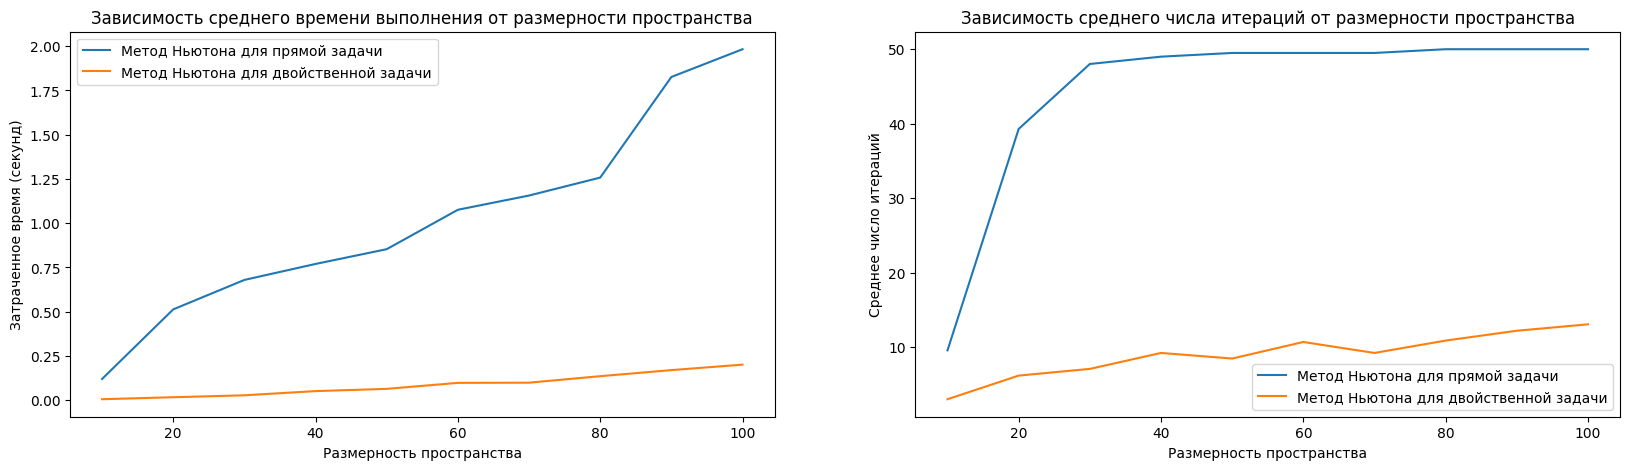

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(20,5)) # создаём фигуру с несколькими подграфиками (ncols и/или nrows) размера figsize

axes[0].plot(n, average_time_newton_prime, label=f"Метод Ньютона для прямой задачи") # построение графика на оси axes
axes[0].plot(n, average_time_newton_dual, label=f"Метод Ньютона для двойственной задачи") # построение графика на оси axes
axes[0].set_title("Зависимость среднего времени выполнения от размерности пространства") # название фигуры
axes[0].set_xlabel("Размерность пространства") # подпись по оси OX
axes[0].set_ylabel("Затраченное время (секунд)") # подпись по оси OY
axes[0].legend() # отображение подписей графиков

axes[1].plot(n, average_iterations_newton_prime, label=f"Метод Ньютона для прямой задачи") # построение графика на оси axes
axes[1].plot(n, average_iterations_newton_dual, label=f"Метод Ньютона для двойственной задачи") # построение графика на оси axes
axes[1].set_title("Зависимость среднего числа итераций от размерности пространства") # название фигуры
axes[1].set_xlabel("Размерность пространства") # подпись по оси OX
axes[1].set_ylabel("Среднее число итераций") # подпись по оси OY
axes[1].legend() # отображение подписей графиков

plt.show() # показ фигуры

### Число арифметических операций.

Для одной итерации метода Ньютона в ***прямой задаче*** необходимо арифметических операций $n^3 + n^2 + 8n - 1$:
* Подсчёт значения функции $f(x) = \sum_{i=1}^{n}x_i ln(x_i)$:
    * $2n (\text{взятие логарифма и умножение}) + n-1 (сложения)$
* Подсчёт градиента $∇f(x) = ln(x) + 1$:
    * $2n (\text{взятие логарифма и прибавление 1})$
* Подсчёт Гессиана $\frac{d^2f(x)}{dx^2} = \begin{pmatrix} \frac{1}{x_1} & 0 & ... & 0 \\ ... & ... & ... & ... \\ 0 & ... & 0 & \frac{1}{x_n} \end{pmatrix}$:
    * $n (деление)$
* Обновление текущего значения $x = x - η (\frac{d^2f(x)}{dx^2})^{-1} ∇f(x)$:
    * $n^3 (\text{нахождение обратной матрицы для Гессиана методом Гаусса-Жордана}) + n^2 (\text{умножение обратной матрицы Гессиана на вектор градиента}) + n (\text{умножение на шаг η}) + n (\text{вычитание из текущего значения x}) = n^3 + n^2 + 2n$
* Поиск проекции на допустимую область:
    * да

Для ***двойственной задачи*** $n(m+2)(m^3 + m + 1) + m^3 + 2m^2 + 4m + 2$:
* Подсчёт значения функции $g(λ) = -\sum_{i=1}^{n} e^{-1-λ^T A_{*i}} - λ^T b$:
    * $n(m+1+1)(\text{n - сумма по n, m - перемножение векторов }λ^T A_{*i}, \text{1 - вычитание, 1 - возведение e в степень}) + m(\text{перемножение векторов }λ^T b) + 2 (\text{вычитание суммы и }λ^T b)$
* Подсчёт градиента $∇g(λ) = \sum_{i=1}^{n} e^{-1-λ^T A_{*i}} A_{*i} - b$:
    * $n(m+1+1)m (\text{n - сумма по n, m - перемножение векторов }λ^T A_{*i}, \text{1 - вычитание, 1 - возведение e в степень, m - умножение числа на вектор }A_{*i}) + m (\text{вычитание вектора b})$
* Подсчёт Гессиана $∇^2g(λ) = - \sum_{i=1}^{n} e^{-1-λ^T A_{*i}} A_{*i} A_{*i}^T$:
    * $n(m+1+1)mm^2\ (\text{n - сумма по n, m - перемножение векторов }λ^T A_{*i}, \text{1 - вычитание, 1 - возведение e в степень, m - умножение числа на вектор }A_{*i}, m^2 \text{ - умножение вектора на вектор для получения квадратной матрицы}A_{*i}^T) + m^2 (\text{вычитание суммы = умножение Гессиана на -1})$
* Обновление текущего значения $λ = λ - η (\frac{d^2f(λ)}{dλ^2})^{-1} ∇f(λ)$:
    * $m^3 (\text{нахождение обратной матрицы для Гессиана методом Гаусса-Жордана}) + m^2 (\text{умножение обратной матрицы Гессиана на вектор градиента}) + m (\text{умножение на шаг η}) + m (\text{вычитание из текущего значения λ}) = m^3 + m^2 + 2m$

### Точность

Перепишем методы, чтобы из них можно было взять дополнительную информацию о близости к оптимальному результату.

In [20]:
accuracy = {} # словарь под точность ответов для различных начальных точек и методов

A = data[DIM][0]["A"] # матрица А для тест-кейса
b = data[DIM][0]["b"] # вектор b для тест-кейса
η = 1 # значение шага
res_solver = data[DIM][0]["Result solver"] # результат от солвера для тест-кейса

In [21]:
start_points = {"x": [], "λ": []} # словарь под стартовые точки

for p in range(5): # идём по числу случайных стартовых точек
    x = np.random.uniform(low=0.01, high=1, size=(DIM, 1)) # генерируем случайное стартовое значение x (может нарушать ограничение Ax=b)
    start_points["x"].append(x) # добавляем стартовую точку x

    λ = np.random.uniform(low=-1, high=0, size=(A.shape[0], 1)) # генерируем случайное значение λ из равномерного распределения [-1, 0)
    start_points["λ"].append(λ) # добавляем стартовую точку λ

Для прямой задачи.

In [22]:
accuracy["Newton primal"] = {} # словарь под значение Δ при разных начальных точках

for p in range(5): # идём по числу случайных стартовых точек
    accuracy["Newton primal"][p] = [] # список под значение Δ между оптимальным ответом и полученным на итерации

    iterations = 0 # счётчик итераций
    x = start_points["x"][p] # берём стартовую точку
    res_newton_primal = func_primal(x) # значение начального решения для рассматриваемой стартовой точки

    accuracy["Newton primal"][p].append(abs(res_solver - res_newton_primal)) # запоминаем дельту (разницу ответа на старте итераций с оптимальным от солвера)

    while abs(res_solver - res_newton_primal) > ε and iterations < MAX_ITERS: # пока не сошлись с ответом солвера или не превысили число допустимых итераций
        H = func_primal_hessian(x) # Гессиан
        x = x - η * np.linalg.inv(H) @ func_primal_grad(x) # обновляем значение x
        if not constraints_primal(x, A, b): # если нарушили ограничение ~ вышли из допустимой области
            x_proj = projection(x, A, b) # находим проекцию точки на допустимую область
            if x_proj is None: # проверяем, если солвер не смог найти проекцию
                break # выходим из цикла
            x = x_proj # заменяем точку на её проекцию
        
        res_newton_primal = func_primal(x) # считаем значение функции
        
        iterations += 1 # увеличиваем общее число итераций

        accuracy["Newton primal"][p].append(abs(res_solver - res_newton_primal)) # запоминаем дельту (разницу ответа на итерации с оптимальным от солвера)

Для двойственной задачи.

In [23]:
accuracy["Newton dual"] = {} # словарь под значение Δ при разных начальных точках

for p in range(5): # идём по числу случайных стартовых точек
    accuracy["Newton dual"][p] = [] # список под значение Δ между оптимальным ответом и полученным на итерации

    iterations = 0 # счётчик итераций
    λ = start_points["λ"][p] # берём стартовую точку
    res_newton_dual = func_dual(λ, A, b) # значение начального решения для рассматриваемой стартовой точки

    accuracy["Newton dual"][p].append(abs(res_solver - res_newton_dual)) # запоминаем дельту (разницу ответа на старте итераций с оптимальным от солвера)

    while abs(res_solver - res_newton_dual) > ε and iterations < MAX_ITERS: # пока не сошлись с ответом солвера или не превысили число допустимых итераций
        H = func_dual_hessian(λ, A, b) # Гессиан
        λ = λ - η * np.linalg.inv(H) @ func_dual_grad(λ, A, b) # обновляем значение λ

        res_newton_dual = func_dual(λ, A, b) # считаем значение функции
        
        iterations += 1 # увеличиваем общее число итераций

        accuracy["Newton dual"][p].append(abs(res_solver - res_newton_dual)) # запоминаем дельту (разницу ответа на итерации с оптимальным от солвера)

Точность сходимости.

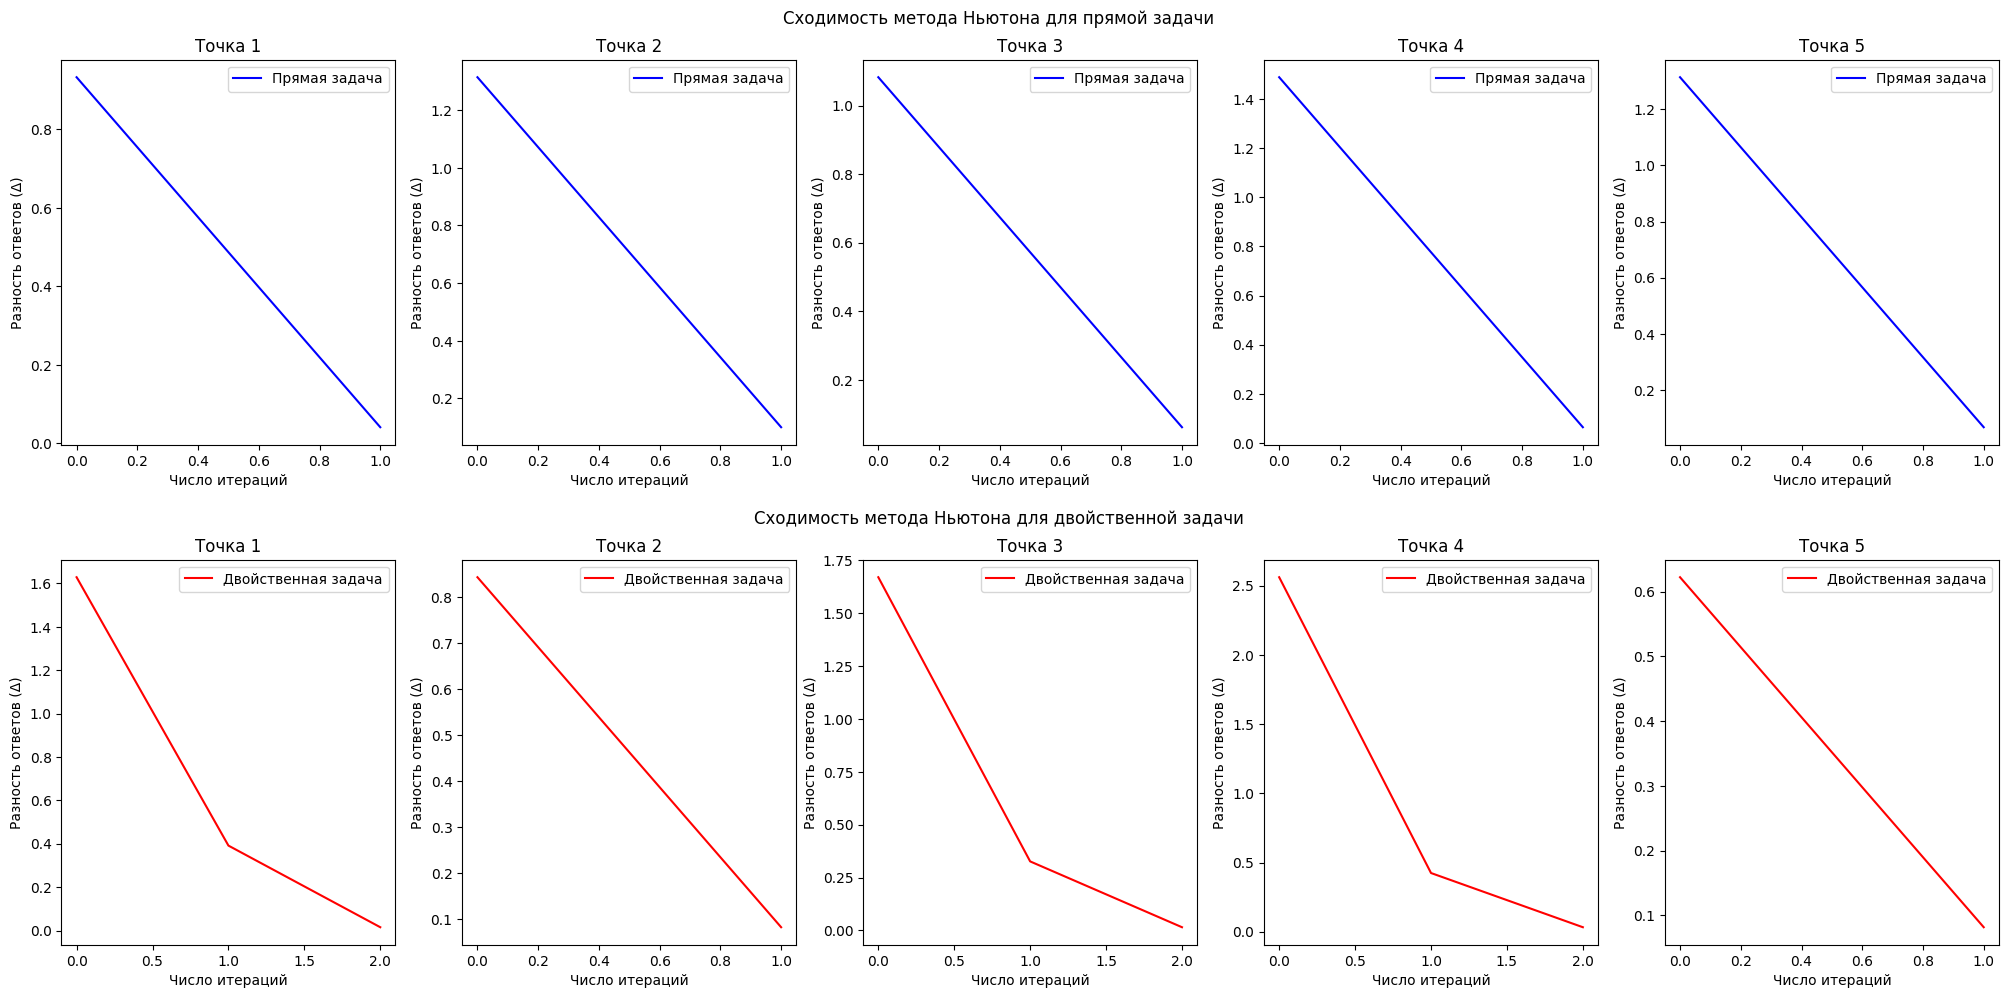

In [24]:
fig = plt.figure(figsize=(25, 10)) # создание фигуры размера figsize
subfigs = fig.subfigures(nrows=2, ncols=1) # создание подфигур (2 строки и всего один столбец)

subfigs[0].suptitle(f"Сходимость метода Ньютона для прямой задачи") # добавление названия строке фигур
axes = subfigs[0].subplots(nrows=1, ncols=5) # создание ncols подфигур в одной строке (под точки)
for col in range(5): # идём по столбцам (точкам) фигуры-строки
    axes[col].plot(range(len(accuracy["Newton primal"][col])), accuracy["Newton primal"][col], "b", label="Прямая задача") # построение графика на оси axes
    axes[col].set_title(f"Точка {col+1}") # название фигуры
    axes[col].set_xlabel("Число итераций") # подпись по оси OX
    axes[col].set_ylabel("Разность ответов (Δ)") # подпись по оси OY
    axes[col].legend() # отображение подписей графиков

subfigs[1].suptitle(f"Сходимость метода Ньютона для двойственной задачи") # добавление названия строке фигур
axes = subfigs[1].subplots(nrows=1, ncols=5) # создание ncols подфигур в одной строке (под точки)
for col in range(5): # идём по столбцам (точкам) фигуры-строки
    axes[col].plot(range(len(accuracy["Newton dual"][col])), accuracy["Newton dual"][col], "r", label="Двойственная задача") # построение графика на оси axes
    axes[col].set_title(f"Точка {col+1}") # название фигуры
    axes[col].set_xlabel("Число итераций") # подпись по оси OX
    axes[col].set_ylabel("Разность ответов (Δ)") # подпись по оси OY
    axes[col].legend() # отображение подписей графиков

plt.show() # показ фигуры

Метод Ньютона показал отличную сходимость для данной двойственной задачи.